In [21]:

import os
import math
import pickle
from argparse import ArgumentParser
import random
import logging

import xgboost
import pandas as pd
import numpy as np
path = "/Users/hadleyvanrenterghem/Documents/CloudC/cloud-project-fall2020/flux/ml/results/xgboost_SGD"

In [22]:
clf = xgboost.XGBRegressor(
            n_estimators=50,
            objective="reg:linear",
            booster="gbtree",
            max_depth=10,
            base_score=2,
            importance_type="gain", # For feature importance
            random_state=1 # Not set in original code
            )

In [230]:
#get feature names
import numpy as np
col = np.array(["time", "first_call", "machine", "agg_net_out_per_machine", "agg_net_in_per_machine", "agg_net_out", "agg_net_in", "flow_frequency", "flow_size"])
cols = np.empty((0,))
for i in range(4,0,-1):
    flow = "_" + str(i)
    flowInfo = np.char.add(col, flow)
    cols = np.concatenate((cols, flowInfo), axis=None)
#last one does not include flow size
flow = "_" + str(0)
flowInfo = np.char.add(col[0:-1], flow)
cols = np.concatenate((cols, flowInfo), axis=None)
    



In [130]:
print(cols)

['time_4' 'first_call_4' 'machine_4' 'agg_net_out_per_machine_4'
 'agg_net_in_per_machine_4' 'agg_net_out_4' 'agg_net_in_4'
 'flow_frequency_4' 'flow_size_4' 'time_3' 'first_call_3' 'machine_3'
 'agg_net_out_per_machine_3' 'agg_net_in_per_machine_3' 'agg_net_out_3'
 'agg_net_in_3' 'flow_frequency_3' 'flow_size_3' 'time_2' 'first_call_2'
 'machine_2' 'agg_net_out_per_machine_2' 'agg_net_in_per_machine_2'
 'agg_net_out_2' 'agg_net_in_2' 'flow_frequency_2' 'flow_size_2' 'time_1'
 'first_call_1' 'machine_1' 'agg_net_out_per_machine_1'
 'agg_net_in_per_machine_1' 'agg_net_out_1' 'agg_net_in_1'
 'flow_frequency_1' 'flow_size_1' 'time_0' 'first_call_0' 'machine_0'
 'agg_net_out_per_machine_0' 'agg_net_in_per_machine_0' 'agg_net_out_0'
 'agg_net_in_0' 'flow_frequency_0']


In [229]:
clf.load_model(path)
import matplotlib.pyplot as plt


[01:19:12] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [189]:
scores = clf.get_booster().get_score(importance_type='gain')
print(len(scores))


44


In [190]:
feature_importance = np.empty((len(scores),1))
for feature_num in range(0,43):
    feature_name = cols[feature_num]
    feature_key = "f" + str(feature_num)
    feature_importance[feature_num] = scores[feature_key]

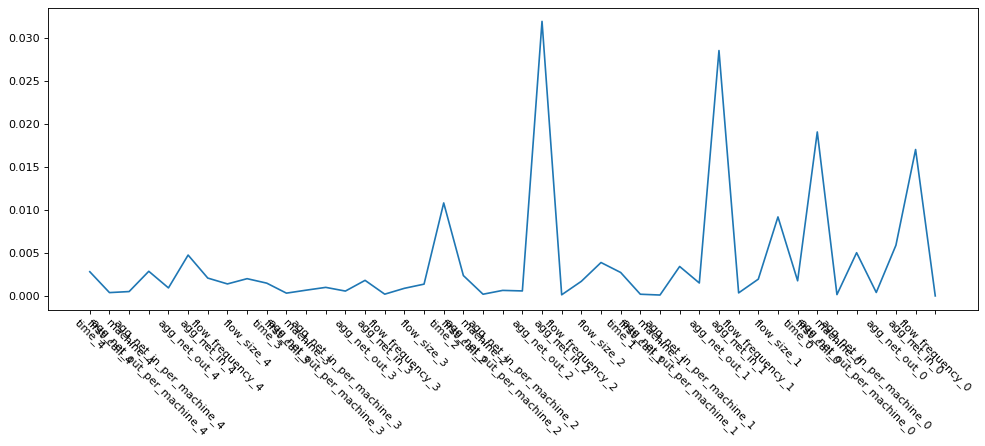

In [191]:
fig = plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k');
plt.plot(cols, feature_importance);
plt.xticks(rotation=-45);

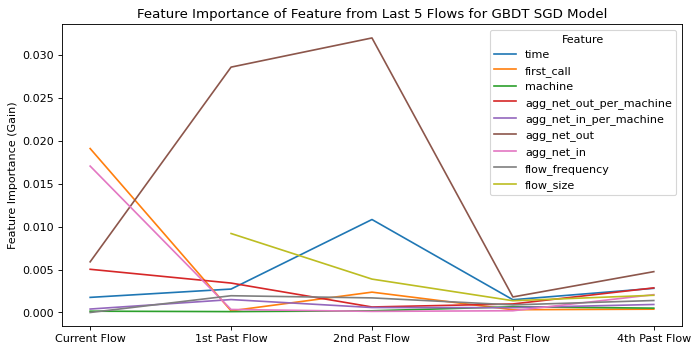

In [196]:
fig = plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
feature_sums = np.empty((9,))
for feature in range(0,9):
    name = cols[feature]
    values = feature_importance[feature::9]
    feature_sums[feature] = np.sum(values)
    names = cols[feature::9]
    inds = 4 - np.arange(0, len(values))
    plt.plot(inds,values, label=name[0:-2])
    plt.legend()
    plt.title('Feature Importance of Feature from Last 5 Flows for GBDT SGD Model')
plt.xticks(np.arange(0,5), ['Current Flow', '1st Past Flow', '2nd Past Flow', '3rd Past Flow', '4th Past Flow'])  # Set text labels.
plt.ylabel('Feature Importance (Gain)')
plt.legend(title = "Feature")


In [228]:
import seaborn as sns
import pylab

vars = np.array(["time", "previous_flow_time", "agg_net_out", "agg_net_in", "agg_net_out_per_machine", "agg_net_in_per_machine", "tcp_queue", "machine", "cpu", "ram", "disk_write", "memory_read", "memory_write", "first_call", "flow_size","flow_frequency"]);
colorDict = {} 
cm = pylab.get_cmap('nipy_spectral')
for i in range(len(vars)):
    colorDict[vars[i]] = cm(1.*i/15)  # color will now be an RGBA tuple
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Text(0.5, 1.0, '%Contributions SGD Model')

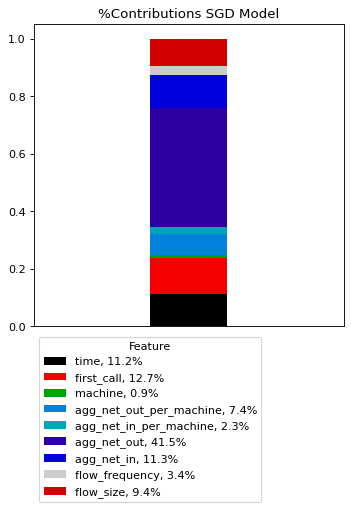

In [231]:
fig = plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
feature_sum = feature_sums/np.sum(feature_sums)

barWidth = .5
cumSum = 0
for i in range(len(feature_sum)):  
    # Create green Bars
    name = col[i];
    plt.bar(0, feature_sum[i], bottom = cumSum, color = colorDict[name], width=barWidth, label = name + ", " + str(round(feature_sum[i]*100 ,1))+"%")
    plt.xlim(-1,1)
    cumSum = cumSum + feature_sum[i]
plt.legend(loc='lower left',bbox_to_anchor=(0, -.6, 1, 0.5),title = "Feature")

ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.title("%Contributions SGD Model")
# orange Bars

Text(0.5, 1.0, '%Contributions SGD Model')

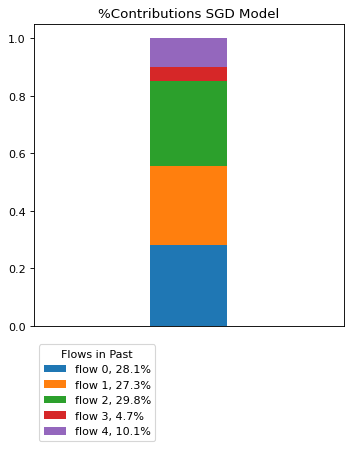

In [225]:
fig = plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
flow_sum = np.empty((5,))
flow_sum[4] = np.sum(feature_importance[0:9])
flow_sum[3] = np.sum(feature_importance[9:18])
flow_sum[2] = np.sum(feature_importance[18:27])
flow_sum[1] = np.sum(feature_importance[27:36])
flow_sum[0] = np.sum(feature_importance[36:44])
flow_sum = flow_sum/np.sum(flow_sum)
barWidth = .5
cumSum = 0
for i in range(len(flow_sum)):  
    # Create green Bars
    plt.bar(0, flow_sum[i], bottom = cumSum, width=barWidth, label = "flow " + str(i)+ ", " + str(round(flow_sum[i]*100 ,1))+"%")
    plt.xlim(-1,1)
    cumSum = cumSum + flow_sum[i]
plt.legend(loc='lower left',bbox_to_anchor=(0, -.4, 1, 0.5),title = "Flows in Past")

ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.title("%Contributions SGD Model")
# orange Bars
# orange Bars

In [105]:
#double check feature names
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/hadleyvanrenterghem/Documents/CloudC/cloud-project-fall2020/flux/ml')
import xgboost_util


In [117]:
TRAINING_PATH = "/Users/hadleyvanrenterghem/Documents/CloudC/ml/SGD/training"    
training_files = [os.path.join(TRAINING_PATH, f) for f in os.listdir(TRAINING_PATH)]

scaling = xgboost_util.calculate_scaling(training_files)
data = xgboost_util.prepare_files(training_files, 5, scaling)
inputs, outputs = xgboost_util.make_io(data)


In [141]:
print(cols)
print(data)
#yes these appear to be in same order

['time_4' 'first_call_4' 'machine_4' 'agg_net_out_per_machine_4'
 'agg_net_in_per_machine_4' 'agg_net_out_4' 'agg_net_in_4'
 'flow_frequency_4' 'flow_size_4' 'time_3' 'first_call_3' 'machine_3'
 'agg_net_out_per_machine_3' 'agg_net_in_per_machine_3' 'agg_net_out_3'
 'agg_net_in_3' 'flow_frequency_3' 'flow_size_3' 'time_2' 'first_call_2'
 'machine_2' 'agg_net_out_per_machine_2' 'agg_net_in_per_machine_2'
 'agg_net_out_2' 'agg_net_in_2' 'flow_frequency_2' 'flow_size_2' 'time_1'
 'first_call_1' 'machine_1' 'agg_net_out_per_machine_1'
 'agg_net_in_per_machine_1' 'agg_net_out_1' 'agg_net_in_1'
 'flow_frequency_1' 'flow_size_1' 'time_0' 'first_call_0' 'machine_0'
 'agg_net_out_per_machine_0' 'agg_net_in_per_machine_0' 'agg_net_out_0'
 'agg_net_in_0' 'flow_frequency_0']
[(         time4  first_call4  machine4  agg_net_out_per_machine4  \
0     0.000000     0.000000  0.000000              0.000000e+00   
1     0.000000     0.000000  0.000000              0.000000e+00   
2     0.000000     0.00

In [140]:
print(inputs.shape)

(515473, 44)
